In [1]:
import kaggle

# Download latest version
kaggle.api.dataset_download_files("vinayakshanawad/cement-manufacturing-concrete-dataset", path='./Data/', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/vinayakshanawad/cement-manufacturing-concrete-dataset


Ingredient Correlation Analysis

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
df = pd.read_csv("data/concrete.csv")

In [4]:
# Check correlations between all variables, including compressive strength
correlation_matrix = df.corr()

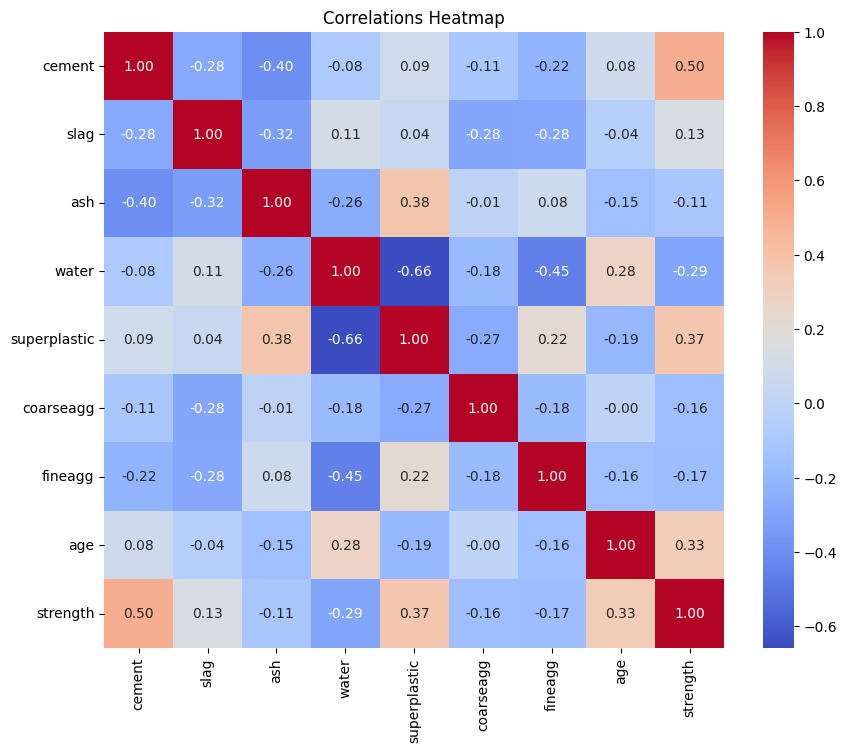

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlations Heatmap")
plt.show()

In [6]:
# Check the correlation of each ingredient with compressive strength
resistance = 'strength' 
ingredients = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age']
for ingredient in ingredients:
    corr, _ = pearsonr(df[ingredient], df[resistance])
    print(f"Correlation between {ingredient} and compressive strength: {corr:.2f}")


Correlation between cement and compressive strength: 0.50
Correlation between slag and compressive strength: 0.13
Correlation between ash and compressive strength: -0.11
Correlation between water and compressive strength: -0.29
Correlation between superplastic and compressive strength: 0.37
Correlation between coarseagg and compressive strength: -0.16
Correlation between fineagg and compressive strength: -0.17
Correlation between age and compressive strength: 0.33


The results suggest that:
Cement and superplasticizers are the main positive contributors to compressive strength.
Water and aggregates show negative correlations, indicating that excessive amounts of these materials can reduce strength.
Curing age has a significant positive influence, confirming that concrete becomes stronger with age.

Predictive Modeling of Compressive Strength

In [7]:
# Define the independent variables (ingredients) and the dependent variable (compressive strength)
X = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age']]
y = df['strength']


In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Create the linear regression model and train it
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [9]:
# Make predictions with the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error and R-squared
# mse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred) #deprecated
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 114.64908528564052
R-squared: 0.5928589712433964


In [10]:
# Display coefficients of each ingredient to interpret their importance in resistance
coef_df = pd.DataFrame(model.coef_, X.columns, columns=['Coeficient'])
print("\nCoefficients of each ingredient:\n", coef_df)


Coefficients of each ingredient:
               Coeficient
cement          0.121197
slag            0.103781
ash             0.095849
water          -0.182388
superplastic    0.195249
coarseagg       0.018249
fineagg         0.020599
age             0.118083


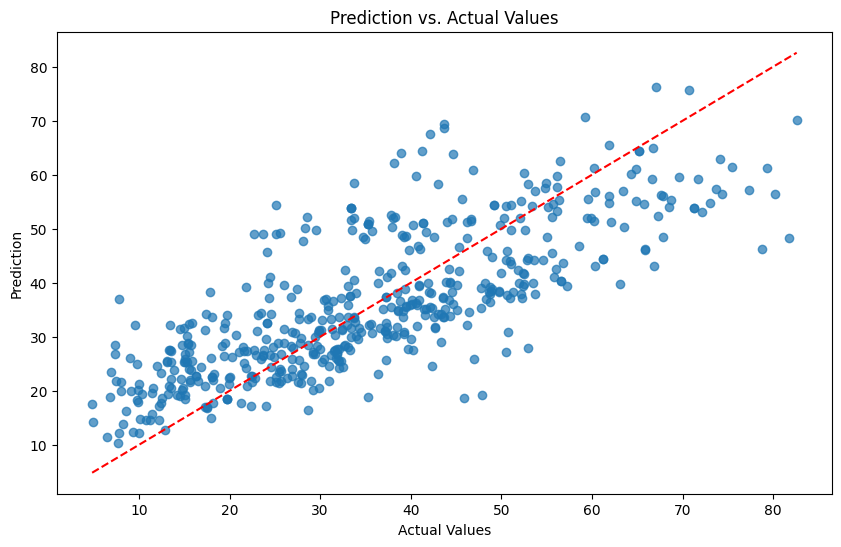

In [11]:
# Prediction vs. Actual Values ​​Graph
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45 degree line for reference
plt.xlabel("Actual Values")
plt.ylabel("Prediction")
plt.title("Prediction vs. Actual Values")
plt.show()

Each point represents a pair of actual and predicted values.
The red dashed 45-degree line represents where perfect predictions would be (where the prediction is exactly equal to the actual value).
The closer the points are to this line, the better the model.

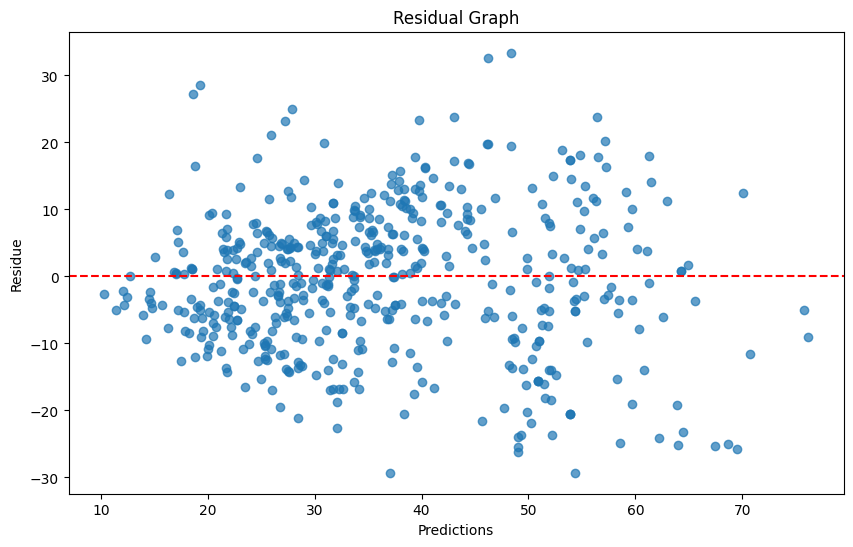

In [12]:
# Residual Graph
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predictions")
plt.ylabel("Residue")
plt.title("Residual Graph")
plt.show()

Shows the difference between the actual and predicted values ​​(residuals) relative to the predictions.
The red dashed line at zero represents the ideal position of the residuals.
If the residuals are randomly distributed around zero, this suggests that the model is unbiased and well-suited to the data.

In [13]:
# Define the curing time intervals for analysis
df['age_group'] = pd.cut(df['age'], bins=[0, 7, 28, 56, df['age'].max()], 
                         labels=['0-7 days', '8-28 days', '29-56 days', '57+ days'])

In [14]:
# Calculate the average compressive strength for each curing time group
average_resistance_by_age = df.groupby('age_group', observed=False)['strength'].mean()

print("\nAverage compressive strength per curing time interval:")
print(average_resistance_by_age)


Average compressive strength per curing time interval:
age_group
0-7 days      22.308397
8-28 days     35.730431
29-56 days    51.890220
57+ days      46.973526
Name: strength, dtype: float64


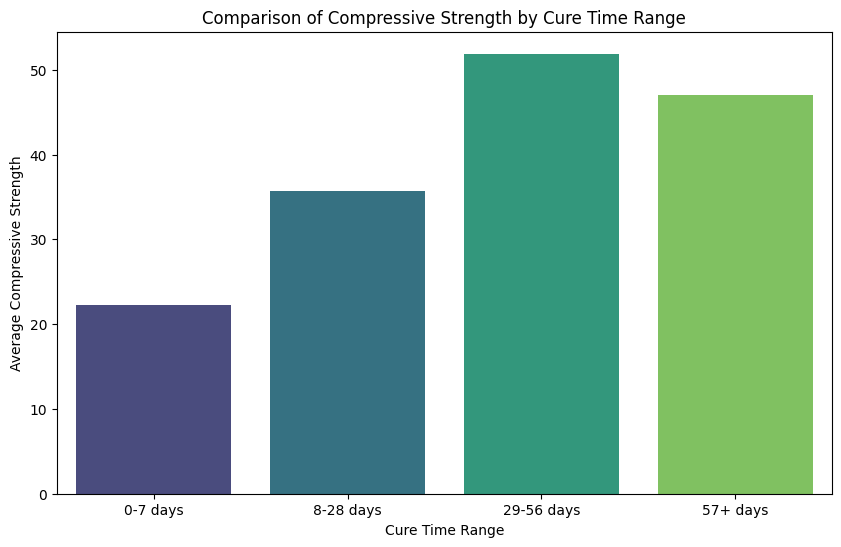

In [15]:
# Plot bar chart for visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=average_resistance_by_age.index, y=average_resistance_by_age.values, palette="viridis", hue=average_resistance_by_age.index, legend=False)
plt.xlabel("Cure Time Range")
plt.ylabel("Average Compressive Strength")
plt.title("Comparison of Compressive Strength by Cure Time Range")
plt.show()

We use a bar graph to display the average strength for each curing time interval. This allows for a clear visual analysis of how the strength of concrete tends to increase with curing time.

In [16]:
# Select only the ingredients and curing time columns for clustering
ingredients = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age']]

# Standardize the data so that all variables have mean 0 and standard deviation 1
scaler = StandardScaler()
ingredients_scaled = scaler.fit_transform(ingredients)

In [17]:
# Determine the number of clusters using the Elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(ingredients_scaled)
    inertia.append(kmeans.inertia_)

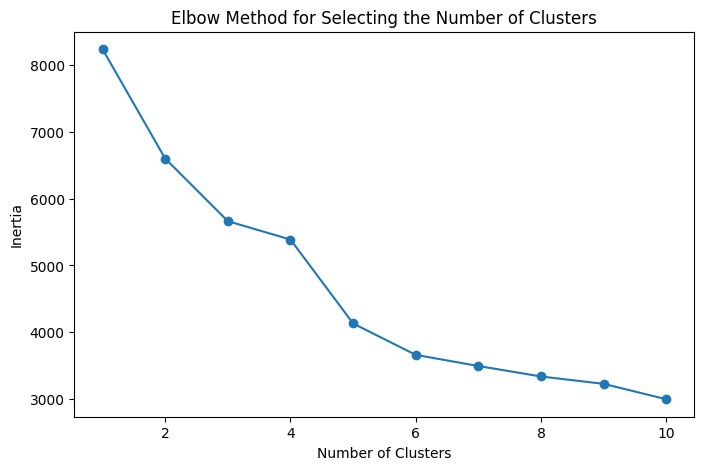

In [18]:
# Plot the Elbow plot to select the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Selecting the Number of Clusters')
plt.show()

Calculate the inertia for different numbers of clusters and plot the "Elbow" graph. The optimal number of clusters is where the inertia starts to slowly decrease (the "elbow" of the graph).

In [19]:
# Choosing the optimal number of clusters based on the Elbow plot
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(ingredients_scaled)

In [20]:
# Add compressive strength column for cluster analysis
df['strength'] = df['strength']

# Analyze the mean of ingredients and strength by cluster
clusters_analise = df.groupby('Cluster').mean('strength').sort_values('strength')
print("\nMean of features in each cluster:")
print(clusters_analise)


Mean of features in each cluster:
             cement        slag         ash       water  superplastic  \
Cluster                                                                 
3        202.313369  190.595722    1.310160  192.317647      2.473262   
2        353.338424    3.261084    0.586207  191.339901      0.351232   
1        220.225000   17.805357  125.393571  168.036071      8.610000   
4        246.173611   89.505556  124.116667  192.570139      8.767361   
0        347.449091   62.696364    0.000000  214.672727      0.000000   
5        396.403106  114.824224   15.322981  159.140994     13.563354   

           coarseagg     fineagg         age   strength  
Cluster                                                  
3         974.184492  754.204813   31.192513  28.885241  
2        1020.366502  769.256158   33.251232  29.561527  
1        1018.593929  806.813571   38.546429  33.587464  
4         878.672917  743.755556   27.250000  34.196319  
0         966.480000  678.352727

Cluster Average: This table shows the average of each ingredient and compressive strength in each cluster. This helps us identify which ingredient mixtures are associated with higher strengths.

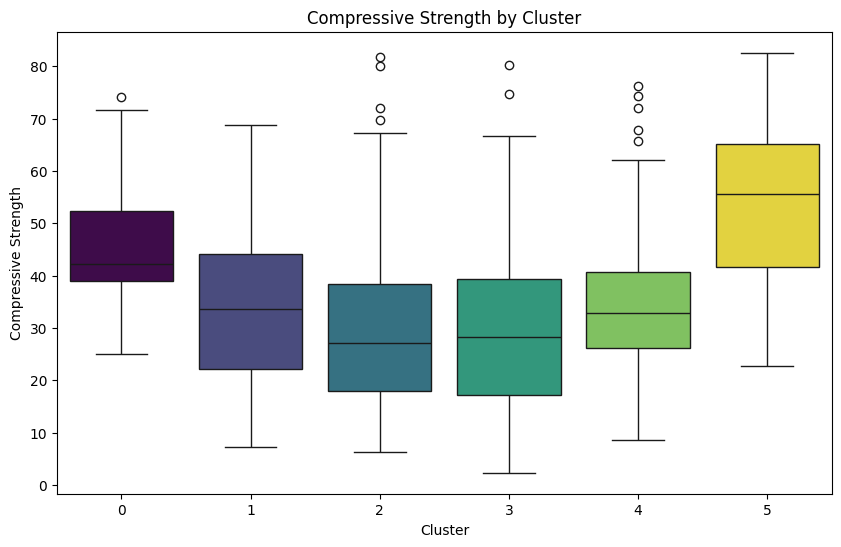

In [21]:
# Visualize clusters in relation to compressive strength
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='strength', data=df, palette='viridis', hue='Cluster', legend=False)
plt.xlabel("Cluster")
plt.ylabel("Compressive Strength")
plt.title("Compressive Strength by Cluster")
plt.show()

Strength by Cluster Plot: The boxplot displays the distribution of compressive strength in each cluster, allowing you to quickly identify which groups have a higher average strength.